# Problem Definition

The problem with tweets is that they are not written formally and therefore before using them in our model we need to actually do a lot of pre-processing to get a meaningful chunk of words



In [51]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk as nlp
nltk.download('punkt')
nltk.download('wordnet')
import re
from scipy import signal
from scipy.stats import shapiro
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [10]:
#load data
Tweets = pd.read_csv(r'C:\Users\Lenovo\Desktop\andalusia\Tweets.csv')
#view Heads of data
Tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [29]:
# check null 
Tweets.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [28]:
Tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

we are use (airline_sentiment , text ,retweet_count )

# Exploratory data analysis (EDA)

In [25]:
Tweets.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [26]:
air_senti=pd.crosstab(Tweets.airline, Tweets.airline_sentiment)
air_senti

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


Plotting the count of Sentiments { Positive, Negative, Neutral}



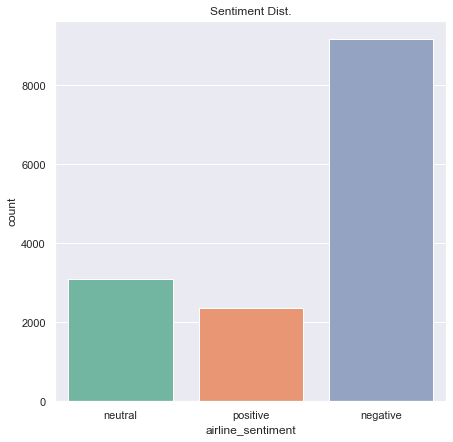

In [13]:
sns.set()
plt.figure(figsize=(7,7))
sns.countplot(x=Tweets["airline_sentiment"],palette="Set2")
plt.title("Sentiment Dist.")
plt.show()

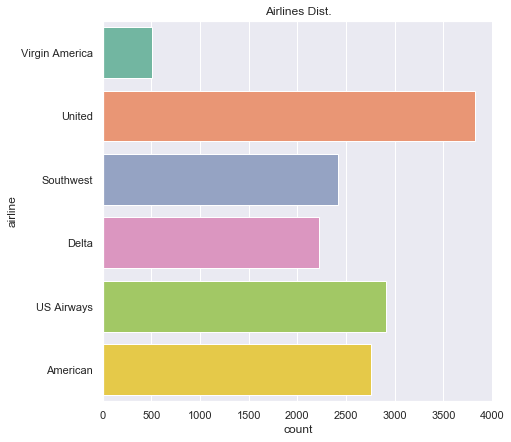

In [14]:
sns.set()
plt.figure(figsize=(7,7))
sns.countplot(y=Tweets["airline"],palette="Set2")
plt.title("Airlines Dist.")
plt.show()

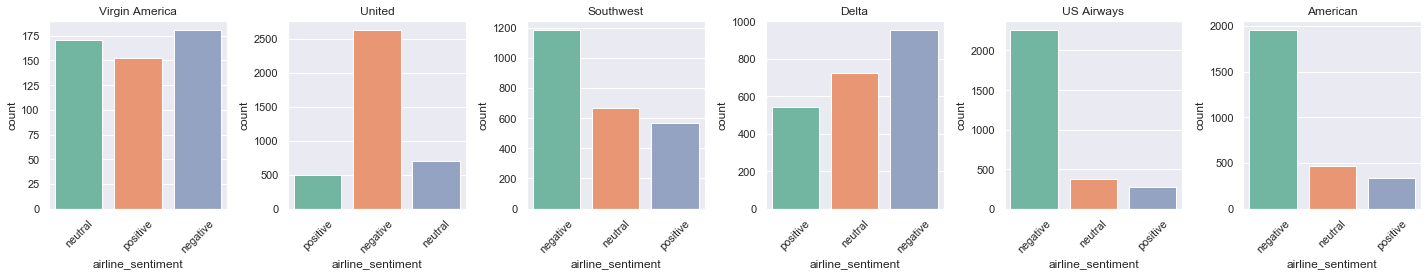

In [16]:
j=1
plt.subplots(figsize=(20,4),tight_layout=True)
for i in Tweets["airline"].unique():
        x = Tweets[Tweets["airline"]==i]
        plt.subplot(1, 6, j)
        sns.countplot(x["airline_sentiment"],palette="Set2")
        plt.xticks(rotation=45)
        plt.title(i)
        j +=1
plt.show()

We are now able to comment on the emotions of the twits about companies. The United airline mentioned above has a very bad reputation in twitter. They also have negative reviews, which can be said that The United airline,US Airways and American offer poor service and have very bad reputation..


In [31]:
print("Day   # of retweet \n%s"%Tweets.retweet_count.value_counts())

Day   # of retweet 
0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64


# Data preparation

In [44]:
lemma = nlp.WordNetLemmatizer()
def preprocess(x):
    x = str(x)
    x = re.sub("[^a-zA-z]", " ",x)
    x = x.lower()
    x = nlp.word_tokenize(x)
    x = [i for i in x if not i in set(stopwords.words("english"))] #slowly
    x = [lemma.lemmatize(i) for  i in x]
    x = " ".join(x)
    return x

Tweets.text = Tweets.text.apply(preprocess)
Tweets['clean_tweet'] = Tweets['text'].apply(preprocess)
Tweets['rating'] = Tweets['airline_sentiment'].apply(lambda x : 0 if x == 'negative' else 1)
Tweets.text[0:10]

0                          virginamerica dhepburn said
1    virginamerica plus added commercial experience...
2    virginamerica today must mean need take anothe...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
5    virginamerica seriously would pay flight seat ...
6    virginamerica yes nearly every time fly vx ear...
7    virginamerica really missed prime opportunity ...
8                                   virginamerica well
9        virginamerica amazing arrived hour early good
Name: text, dtype: object

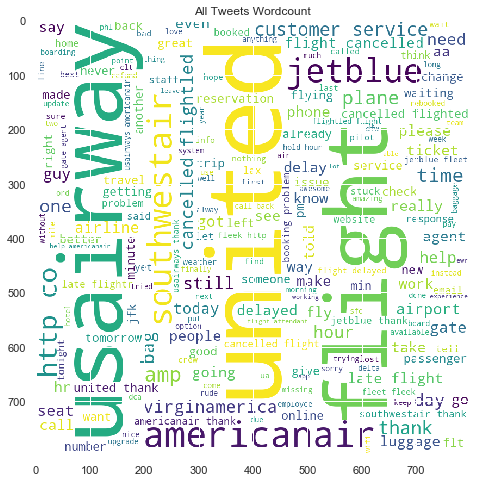

In [24]:
#creating word count
allcomments = " ".join(Tweets.text)
wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = STOPWORDS, 
                    min_font_size = 12).generate(allcomments) 
      
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.title("All Tweets Wordcount")
plt.show()

The Dataset consists of many features, however every features isn't of importance to sentiment classification. There is also a very significant presence of NuLL values in both important and non-important features. For this, I am just taking 2 features which are the most important ones; text and airline_sentiment (target)

In [30]:
tweets=Tweets[["airline_sentiment","text"]]
tweets.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plus added commercial experience...
2,neutral,virginamerica today must mean need take anothe...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


# Hypothesis testing

1- Gaussian distribution 
Assumptions
negative reasons choice are independent and identically distributed (iid).

Interpretation
H0: the sample has a Gaussian distribution.

H1: the sample does not have a Gaussian distribution.

In [55]:
data_Tweets = np.array(Tweets.negativereason.value_counts().tolist(),dtype='float64')
stat, p = shapiro(data_Tweets)
print(p)

0.04575388878583908


We can accept H0 at alpha equals 0.0005 and negative reasons choice has normal dist

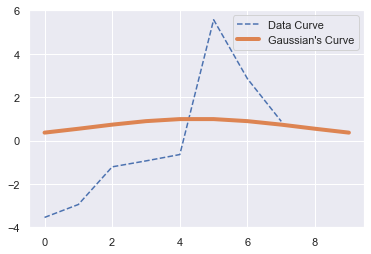

In [59]:

def central_limit_theorem(rv):
    return (rv - np.average(rv))/(np.std(rv)/len(rv)**.5)
def handle_gaussian(l):
    # Make list to be as gaussian dist.
    l = l.tolist()
    l.sort()
    n = len(l)
    i = int(n/2)
    halve1 = l[0:i]
    halve2 = l[i+1:n-1]
    halve2.reverse()
    return halve1 + halve2

gaussian = signal.gaussian(len(data_Tweets), std=np.std(central_limit_theorem(data_Tweets)))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(central_limit_theorem(handle_gaussian(data_Tweets)), label='Data Curve', linestyle='--')
ax.plot(gaussian,label="Gaussian's Curve", linewidth=4)
ax.legend()

plt.show()

Tests whether a retweets has a Gaussian distribution.

Assumptions

retweets are independent and identically distributed (iid).

Interpretation

H0: the sample has a Gaussian distribution. H1: the sample does not have a Gaussian distribution



In [60]:
data_tweet = np.array(Tweets['retweet_count'].value_counts().tolist(),dtype='float64')
stat, p = shapiro(data_tweet)
print(p)


1.4170607798291712e-08


We reject H0 and has no Gaussian's dist

2 - Spearman’s Rank Correlation
Assumptions

Observations in each sample are independent and identically distributed (iid). Observations in each sample can be ranked.

Interpretation

H0: the two samples are independent.

H1: there is a dependency between the samples.

In [63]:
from scipy.stats import spearmanr
data1, data2 = np.array(Tweets.retweet_count.tolist()), np.array(Tweets.airline_sentiment.tolist())
corr, p = spearmanr(data1, data2)
print(p)

1.6916982159471742e-17


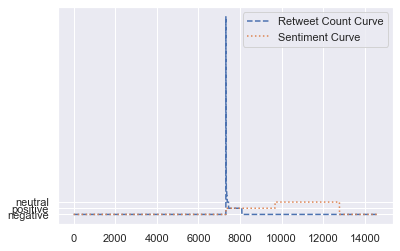

In [64]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(handle_gaussian(data1), label='Retweet Count Curve', linestyle='--')
ax.plot(handle_gaussian(data2),label="Sentiment Curve", linestyle=':')
ax.legend()

plt.show()


In [ ]:
We Accept H0 and has two samples are independent

# Machine Learning Modelling

In [47]:
# Random Forrest Classifier for Classification
tweet_ML_data = Tweets[['clean_tweet', 'rating']]
x = tweet_ML_data['clean_tweet']
y = tweet_ML_data['rating']
countvectorizer = CountVectorizer()
countvectorizermatrix = countvectorizer.fit_transform(x)
tfidf = TfidfTransformer()
tfidfmatrix = tfidf.fit_transform(countvectorizermatrix)
x_train, x_test, y_train, y_test = train_test_split(tfidfmatrix, y, test_size = 0.3, random_state = 101)

In [49]:
model = RandomForestClassifier(n_estimators = 200)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2738
           1       0.80      0.63      0.70      1654

    accuracy                           0.80      4392
   macro avg       0.80      0.76      0.77      4392
weighted avg       0.80      0.80      0.79      4392

[[2472  266]
 [ 617 1037]]


# Validation

-As we you can see above we have plotted the confusion matrix for predicted sentiments and actual sentiments (negative,neutral and positive)
-Random Forest Classifier gives us the best accuracy score, precision scores according to the classification report.